In [1]:
# Setup library
## install -r requirements.txt
from __future__ import absolute_import, division, print_function, unicode_literals
import os
from operator import itemgetter

import matplotlib.pylab as plt
# %matplotlib widget
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Global variables
# Setup scripts (or notebook)
IMG_DATA = './sampled_data_1184'
IMG_SHAPE = (39, 39)
MAX_STEPS = 1000

In [3]:
%%time
# prepare dataset
dataset_root = os.path.abspath(os.path.expanduser(IMG_DATA))
print(f'Dataset root: {dataset_root}')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                  validation_split=0.1)
train_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                 subset='training')
validation_data = image_generator.flow_from_directory(dataset_root, target_size=IMG_SHAPE,
                                                 subset='validation')

for image_batch, label_batch in validation_data:
    print(f'Image batch shape: {image_batch.shape}')
    print(f'Label batch shape: {label_batch.shape}')
    break

class_names = sorted(validation_data.class_indices.items(), key=itemgetter(1))
class_names = np.array([key.title() for key, value in class_names])
print(f'Classes: {class_names}')

Dataset root: /home/harny/Github/tff-app/sampled_data_1184
Found 60775 images belonging to 16 classes.
Found 6747 images belonging to 16 classes.
Image batch shape: (32, 39, 39, 3)
Label batch shape: (32, 16)
Classes: ['Aim' 'Email' 'Facebook' 'Ftps' 'Gmail' 'Hangout' 'Icqchat' 'Netflix'
 'Scp' 'Sftp' 'Skype' 'Spotify' 'Torrent' 'Vimeo' 'Voipbuster' 'Youtube']
CPU times: user 1.66 s, sys: 562 ms, total: 2.22 s
Wall time: 1.78 s


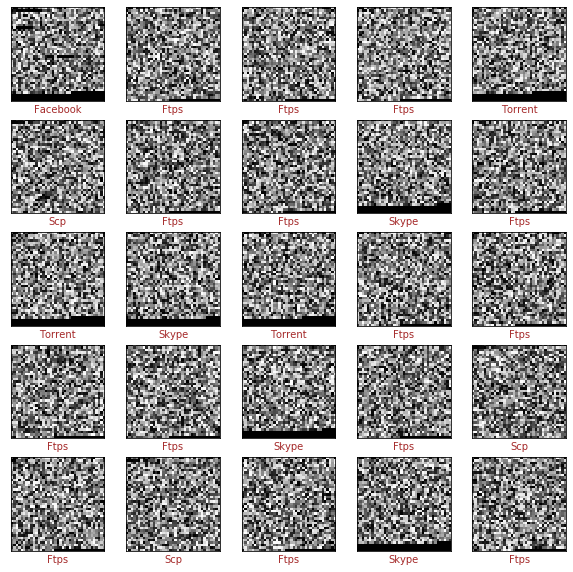

In [4]:
## get result labels
predicted_id = np.argmax(label_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

fig1 = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = fig1.add_subplot(5, 5, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(image_batch[i])
    ax.set_xlabel(predicted_label_batch[i], color='brown')

In [5]:
# Create CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE + (3, )))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(validation_data.class_indices)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 37, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [6]:
# Train build
## Compile model for train
base_learning_rate = 0.001 # default
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

## Log class
### https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_val_losses = []
        self.batch_acc = []
        self.batch_val_acc = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.batch_val_losses.append(logs['val_loss'])
        self.batch_val_acc.append(logs['val_accuracy'])
        self.model.reset_metrics()

In [7]:
steps_per_epoch = np.ceil(train_data.samples/train_data.batch_size) # train all dataset per epoch
initial_epoch = 30
batch_stats_callback = CollectBatchStats()

history = model.fit_generator(train_data,
                              epochs=initial_epoch,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_data,
                              callbacks=[batch_stats_callback])

Epoch 1/30
1900/1900 [==============================] - 86s 45ms/step - loss: 0.7921 - accuracy: 0.7971 - val_loss: 0.6277 - val_accuracy: 0.8350
Epoch 2/30
1900/1900 [==============================] - 85s 45ms/step - loss: 0.2910 - accuracy: 0.9105 - val_loss: 0.3683 - val_accuracy: 0.8905
Epoch 3/30
1900/1900 [==============================] - 86s 45ms/step - loss: 0.1663 - accuracy: 0.9483 - val_loss: 0.2935 - val_accuracy: 0.9329
Epoch 4/30
1900/1900 [==============================] - 87s 46ms/step - loss: 0.1155 - accuracy: 0.9657 - val_loss: 0.2810 - val_accuracy: 0.9395
Epoch 5/30
1900/1900 [==============================] - 86s 45ms/step - loss: 0.0878 - accuracy: 0.9741 - val_loss: 0.2907 - val_accuracy: 0.9481
Epoch 6/30
1900/1900 [==============================] - 87s 46ms/step - loss: 0.0724 - accuracy: 0.9782 - val_loss: 0.3120 - val_accuracy: 0.9420
Epoch 7/30
1900/1900 [==============================] - 86s 45ms/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.2917 -

Text(0.5, 0, 'epoch')

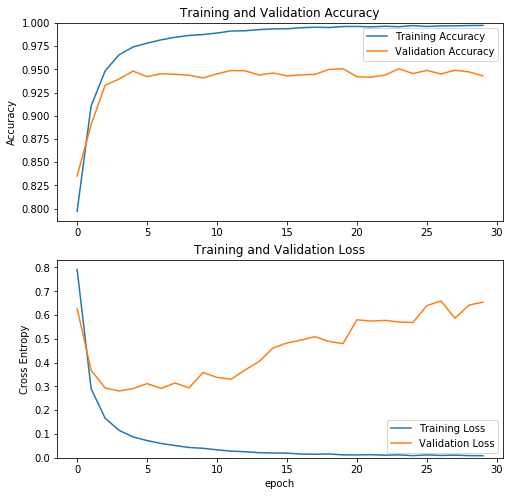

In [8]:
# Draw learning curves chart
acc = batch_stats_callback.batch_acc
val_acc = batch_stats_callback.batch_val_acc
loss = batch_stats_callback.batch_losses
val_loss = batch_stats_callback.batch_val_losses

fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2, 1, 1)
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.legend(loc='upper right')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([min(ax1.get_ylim()),1])
ax1.set_title('Training and Validation Accuracy')

ax2 = fig2.add_subplot(2, 1, 2)
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.legend(loc='lower right')
ax2.set_ylabel('Cross Entropy')
ax2.set_ylim([0,max(ax2.get_ylim())])
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('epoch')

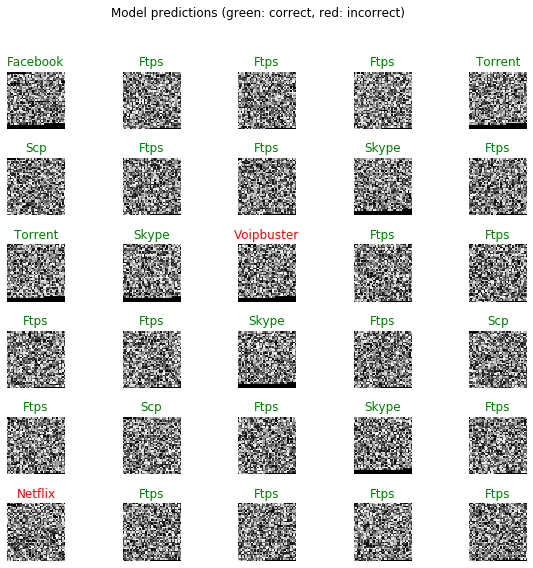

In [9]:
# Plot results
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

## plot
fig3 = plt.figure(figsize=(10,9))
fig3.subplots_adjust(hspace=0.5)
for n in range(30):
    ax = fig3.add_subplot(6, 5, n+1)
    ax.imshow(image_batch[n])
    color = 'green' if predicted_id[n] == label_id[n] else 'red'
    ax.set_title(predicted_label_batch[n].title(), color=color)
    ax.axis('off')
_ = fig3.suptitle('Model predictions (green: correct, red: incorrect)')

In [10]:
# Export model
import time
t = time.time()

export_path = f'./saved_models/{int(t)}'
model.save(export_path, save_format='tf')

print(f'Export the model to {export_path}')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_models/1581840674/assets
Export the model to ./saved_models/1581840674
